# Week 5 Assignment
## Classification - NLCD Impervious Classification (Model Training)

In this assignment you will be shown how to estbalish a logical baseline, train a logistic regression model, and train a decision tree classifier for the binary classification task of classifying each pixel as either "impervious" or "not".

__Raster Files__: 

    - Landsat.tif (remotely sensed data in the form of surface reflactance, will be used as the input to our models) [values (0 - 10000)] numerical
    - Impervious.tif (NLCD fractional impervious map, will be used as our "ground truth" in training some of our modes) [values (0 - 100)] numerical
    - Dem.tif (ancillary data in the form of elevation data) [values (0 - 10000)] numerical
    - Aspect.tif (ancillary data in the form of downslope direction) [values (0 - 8)] categorical
    - Posidex.tif (ancially date in the form of positional index) [values (0 - 100)] numerical
    - Wetlands.tif (ancillary data in the form of wetlands information) [values (0 - 17)] categorical

## 1. Import the required libraries

> __HINT__: Find the libraries you need to import in the assignment instructions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix,  classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

### 1a. Import your binary classification processing functions

>__HINT__: store your functions in a 'functions.py' file in this working directory so you can import them

In [2]:
from functions import binary_classification_preprocess

## 2. Read and transform dataset
> Read in original csv data -> we will create a new processing function for our binary classification task

In [4]:
dataframe = pd.read_csv('s3://geokarma-testing/geoKARMA_h24v13_pixelbased_dataset.csv')
df = binary_classification_preprocess(dataframe)

## 3. Get basic information about the dataset

#### 3a. Print dimensions of the dataset

In [5]:
df.shape

(499835, 43)

#### 3b. Print the first five observations

In [6]:
df.head()

,landsat_1,landsat_2,landsat_3,landsat_4,landsat_5,landsat_6,dem_1,posidex_1,landcover_1,impervious_1,...,aspect_1_17,aspect_1_18,wetlands_1_0,wetlands_1_2,wetlands_1_3,wetlands_1_4,wetlands_1_5,wetlands_1_6,wetlands_1_7,wetlands_1_8
0,164,373,233,2592,1096,429,254.0,47,42,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,271,418,292,2782,1439,635,257.0,28,41,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,454,832,850,3860,2671,1476,277.0,45,81,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,187,345,198,2469,1117,441,242.0,27,42,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,481,715,731,3519,2286,1386,239.0,91,21,13,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 3c. Print the dataset columns

In [7]:
df.columns

Index(['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5',
       'landsat_6', 'dem_1', 'posidex_1', 'landcover_1', 'impervious_1',
       'urban_count_7', 'urban_count_5', 'urban_count_3', 'xgeo', 'ygeo',
       'class', 'aspect_1_0', 'aspect_1_1', 'aspect_1_2', 'aspect_1_3',
       'aspect_1_4', 'aspect_1_5', 'aspect_1_6', 'aspect_1_7', 'aspect_1_8',
       'aspect_1_9', 'aspect_1_10', 'aspect_1_11', 'aspect_1_12',
       'aspect_1_13', 'aspect_1_14', 'aspect_1_15', 'aspect_1_16',
       'aspect_1_17', 'aspect_1_18', 'wetlands_1_0', 'wetlands_1_2',
       'wetlands_1_3', 'wetlands_1_4', 'wetlands_1_5', 'wetlands_1_6',
       'wetlands_1_7', 'wetlands_1_8'],
      dtype='object')

## FITTING THE MODEL

## 4. Feature Selection


#### 4a Assign the target and feature variables
> Assign “class” as the target variable called __target__ and __features__ = ['landsat_{i}', 'dem_1', 'posidex_1', 'aspect_1_{i}', 'wetlands_1_{i}'] 

> __RECAP__: __Target variable__ is the dependent variable. That is, the variable whose value we want to predict.

> __Feature variable__ is the independent variable ie the variables which are used to predict the value of the dependent variable


Why can't we use impervious_1 as an input feature into the model? Might be on the quiz 

In [9]:
features = [
    'landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6', 'dem_1', 'posidex_1',
    'aspect_1_0', 'aspect_1_1', 'aspect_1_2', 'aspect_1_3', 'aspect_1_4', 'aspect_1_5',
    'aspect_1_6', 'aspect_1_7', 'aspect_1_8', 'aspect_1_9', 'aspect_1_10', 'aspect_1_11',
    'aspect_1_12', 'aspect_1_13', 'aspect_1_14', 'aspect_1_15', 'aspect_1_16',
    'aspect_1_17', 'aspect_1_18', 'wetlands_1_0', 'wetlands_1_2', 'wetlands_1_3',
    'wetlands_1_4', 'wetlands_1_5', 'wetlands_1_6', 'wetlands_1_7', 'wetlands_1_8']
target = 'class'

## 5. Split data into train and test sets

> __RECAP__: The model is trained on the __train set__. It is used to fit the model.

> The __test set__ is used to evaluate the performance of the model.

In [10]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#### 5b. Print dimensions of the train and test sets

In [11]:
X_train.shape, X_test.shape

((349884, 35), (149951, 35))

#### 5c. Print the relative frequencies of the unique values in "y_train" and "y_test"
> __HINT__: You can find the code in the assignment instructions

In [12]:
print(f"The relative frequencies in y_train are:\n{y_train.value_counts(normalize=True)}" )
print(f"\nThe relative frequencies in y_train are:\n{y_test.value_counts(normalize=True)}")

The relative frequencies in y_train are:
class
0    0.737027
1    0.262973
Name: proportion, dtype: float64

The relative frequencies in y_train are:
class
0    0.737934
1    0.262066
Name: proportion, dtype: float64


## 6. Logistic regression

#### 6a. Fit the logistic regression model

> __HINT__: You can check the assignment instructions for the code

In [13]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

#### 6b. Make majority prediction 

> Here, the model predicts everything as the most common class.

> __HINT__: You can check the assignment instructions for the code

In [14]:
majority_class = y_train.mode().iloc[0]
majority_class

0

In [15]:
train_pred_majority = [majority_class]*y_train.shape[0]
test_pred_majority = [majority_class]*y_test.shape[0]

#### 6c. Make random prediction 

> This is a binary classifier so the model predicts either 0 or 1 randomly.

> __HINT__: You can check the assignment instructions for the code

In [16]:
train_pred_random = np.random.choice(y_train.unique(), y_train.shape[0])
test_pred_random = np.random.choice(y_train.unique(), y_test.shape[0])

#### 6d. Model Performance 

> predict class labels for samples in the train set and assign it to "train_pred"

> predict class labels for samples in the test set and assign it to "test_pred"

In [17]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

#### 6e. Print accuracy of the train and test sets using with the logistic regression method
> Accuracy measures how many observations, both positive and negative, were correctly classified

> __HINT__: You can check the assignment instructions for the code

In [18]:
print('Logistic regression accuracy of the train set is: ', accuracy_score(y_train, train_pred).round(3))
print('Logistic regression accuracy of the test set is: ', accuracy_score(y_test, test_pred).round(3))


Logistic regression accuracy of the train set is:  0.808
Logistic regression accuracy of the test set is:  0.808


#### 6f. Print accuracy of the train and test sets with the majority prediction method
> __HINT__: You can see how to do this by checking the assignment instructions

In [19]:
print('Majority prediction accuracy of the train set is: ', accuracy_score(y_train, train_pred_majority).round(3))
print('Majority prediction accuracy of the test set is: ', accuracy_score(y_test, test_pred_majority).round(3))

Majority prediction accuracy of the train set is:  0.737
Majority prediction accuracy of the test set is:  0.738


#### 6g. Print accuracy of the train and test sets with the random prediction method
> __HINT__: You can see how to do this by checking the assignment instructions

In [20]:
print('Random prediction accuracy of the train set is: ', accuracy_score(y_train, train_pred_random).round(3))
print('Random prediction accuracy of the test set is: ', accuracy_score(y_test, test_pred_random).round(3))

Random prediction accuracy of the train set is:  0.5
Random prediction accuracy of the test set is:  0.5


## 7. Decision Tree

> A decision tree is a type of supervised machine learning used to categorize or make predictions based on the labelled data provided to it.

Set the following constraints while fitting the decision tree:

- max_depth = 4
- max_features = sqrt (this means, max_features=sqrt(n_features))

> __EXTRA__: Try to build decision trees with different values of max_depth and max_features and evaluate their performance

In [23]:
model = DecisionTreeClassifier(max_depth=4, max_features='sqrt')
model = model.fit(X_train, y_train)

## 8. Feature Importance

#### 8a. Create a dataframe that shows the importance of different features in predicting the target variable in the model   

> __HINT:__ You can find the code in the assignment instructions

In [24]:
imd_df = pd.DataFrame({'feature':features,'importance':model.feature_importances_})
imd_df = imd_df.sort_values(by = 'importance', ascending=False)
imd_df

,feature,importance
5,landsat_6,5.003520e-01
3,landsat_4,2.625586e-01
2,landsat_3,1.328874e-01
6,dem_1,1.008177e-01
30,wetlands_1_4,2.291027e-03
0,landsat_1,6.901957e-04
29,wetlands_1_3,2.060989e-04
31,wetlands_1_5,1.133949e-04
1,landsat_2,4.616103e-05
22,aspect_1_14,3.685549e-05


#### 8b. Print the first 5 observations of the dataframe

In [25]:
imd_df.head()

,feature,importance
5,landsat_6,0.500352
3,landsat_4,0.262559
2,landsat_3,0.132887
6,dem_1,0.100818
30,wetlands_1_4,0.002291


## 9. Visualizing the decision tree

[Text(0.5431034482758621, 0.9, 'landsat_4 <= 3110.5\ngini = 0.388\nsamples = 349884\nvalue = [257874, 92010]\nclass = non-impervious'),
 Text(0.27586206896551724, 0.7, 'landsat_6 <= 613.5\ngini = 0.485\nsamples = 144976\nvalue = [85145, 59831]\nclass = non-impervious'),
 Text(0.13793103448275862, 0.5, 'aspect_1_14 <= 0.5\ngini = 0.224\nsamples = 68186\nvalue = [59430, 8756]\nclass = non-impervious'),
 Text(0.06896551724137931, 0.3, 'wetlands_1_3 <= 0.5\ngini = 0.223\nsamples = 63947\nvalue = [55791, 8156]\nclass = non-impervious'),
 Text(0.034482758620689655, 0.1, 'gini = 0.224\nsamples = 63075\nvalue = [54969, 8106]\nclass = non-impervious'),
 Text(0.10344827586206896, 0.1, 'gini = 0.108\nsamples = 872\nvalue = [822, 50]\nclass = non-impervious'),
 Text(0.20689655172413793, 0.3, 'landsat_3 <= 227.5\ngini = 0.243\nsamples = 4239\nvalue = [3639, 600]\nclass = non-impervious'),
 Text(0.1724137931034483, 0.1, 'gini = 0.131\nsamples = 2916\nvalue = [2711, 205]\nclass = non-impervious'),
 T

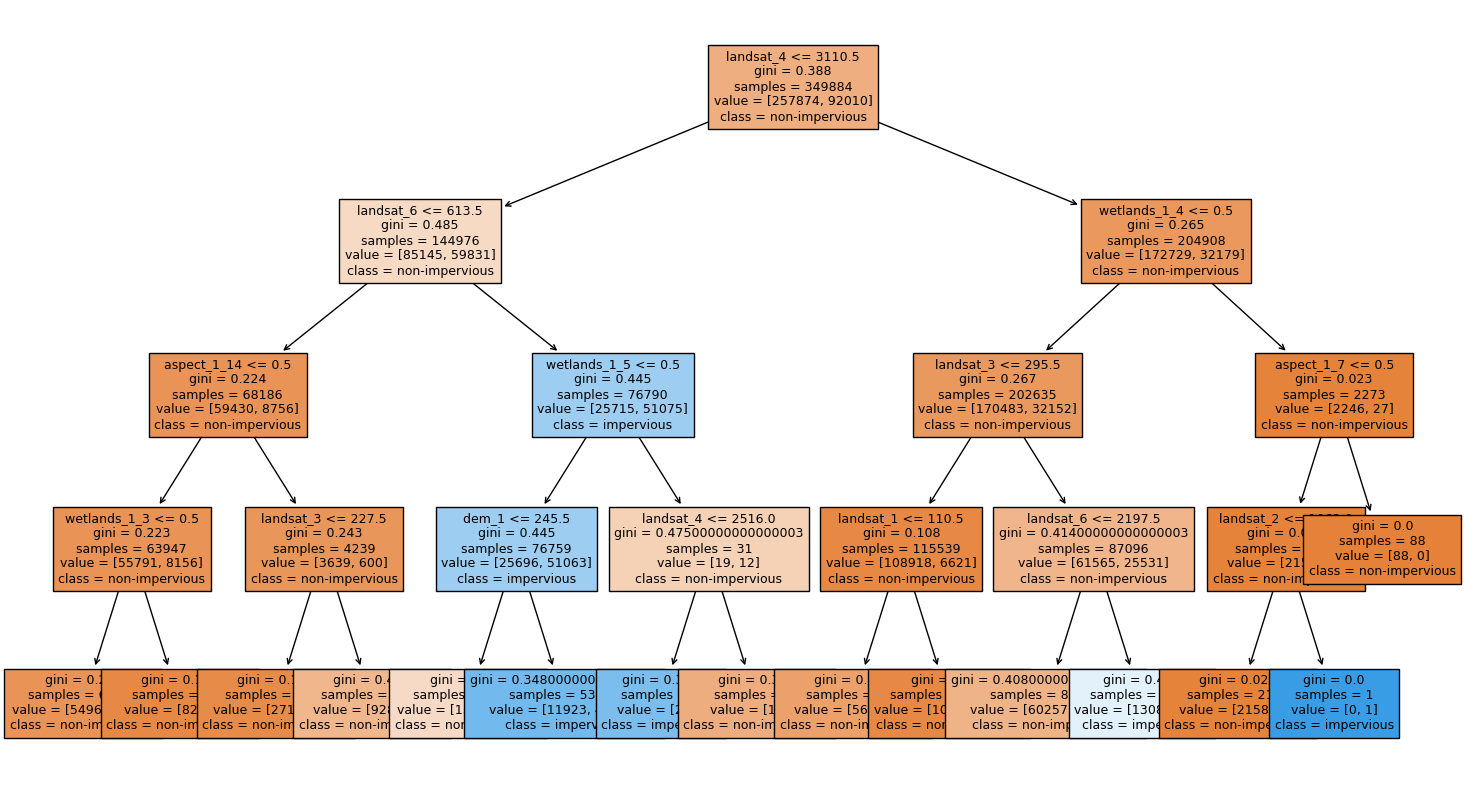

In [26]:
class_names = ['non-impervious', 'impervious']
plt.figure(figsize=(18,10))
plot_tree(model, feature_names=features, filled=True, class_names=class_names,  fontsize=9)

In [27]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)


In [28]:
print('Decision tree accuracy of the train set is: ', accuracy_score(y_train, train_pred).round(3))
print('Decision tree accuracy of the test set is: ', accuracy_score(y_test, test_pred).round(3))


Decision tree accuracy of the train set is:  0.8220000000000001
Decision tree accuracy of the test set is:  0.8200000000000001


## 10. Model evaluation

#### 10a. Print classification report for the train set
> __HINT__: You can check the assignment instructions for the code

> How would you interpret the results?

> Precision is calculated by dividing the true positives by anything that was predicted as a positive.

> __Precision  = TP/ (TP + FP)__

> Recall (or True Positive Rate) is calculated by dividing the true positives by anything that should have been predicted as positive.

> __Recall = TP/(TP + FN)__

> F1 score : harmonic mean of precision and recall

In [29]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89    257874
           1       0.76      0.47      0.58     92010

    accuracy                           0.82    349884
   macro avg       0.80      0.71      0.73    349884
weighted avg       0.81      0.82      0.81    349884



#### 10b. Print classification report for the test set

In [30]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89    110654
           1       0.76      0.46      0.57     39297

    accuracy                           0.82    149951
   macro avg       0.79      0.70      0.73    149951
weighted avg       0.81      0.82      0.80    149951



#### 10c. Print confusion matrix and heatmap for the test set

> what conclusions can be drawn from the confusion matrix? does the model do better predicting one class over the other?

In [31]:
cnf_matrix = metrics.confusion_matrix(y_test, test_pred)
cnf_matrix

array([[104869,   5785],
       [ 21222,  18075]])

Text(0.5, 427.9555555555555, 'Predicted label')

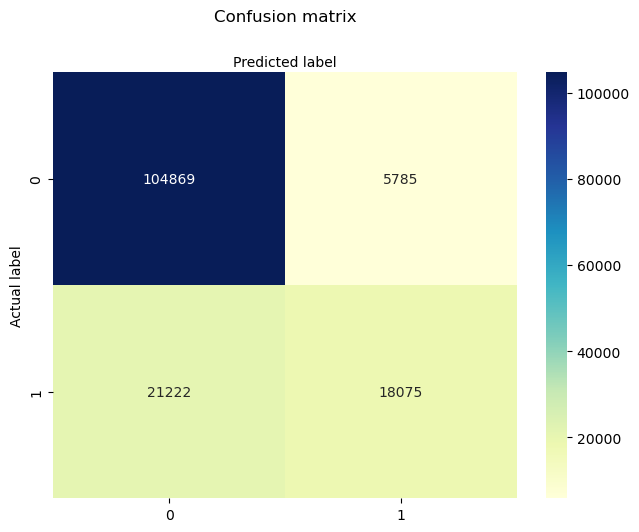

In [32]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## OPTIONAL: Overfitting of decision trees

> You have learned that without setting any limits on the tree, it overfits the model. 

> Try it out yourself - Construct a decision tree without any constraints and see what happens.

In [34]:
model2 = DecisionTreeClassifier()
model2 = model2.fit(X_train, y_train)

In [37]:
train_pred2 = model2.predict(X_train)
test_pred2 = model2.predict(X_test)

In [38]:
print('Decision tree accuracy of the train set is: ', accuracy_score(y_train, train_pred2).round(3))
print('Decision tree accuracy of the test set is: ', accuracy_score(y_test, test_pred2).round(3))

Decision tree accuracy of the train set is:  1.0
Decision tree accuracy of the test set is:  0.81


> You can see that this is a clear case of overfitiing. That is, the decision tree perfectly fits all samples in the training data set but performs poorly on the testing data set. A good model should not only fit the training data well but also accurately classify the data it has never seen.

> That is why we set constraints on the tree to avoid overfitting.